In [99]:
import logging

logger = logging.getLogger(__name__)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
import subprocess

def make(target):
    """Uses GNU make to produce a target.

    Parameters
    ----------
    target : str
        The name of the target.
    """

    logger.info('Making target {}'.format(target))
    command = 'nice -n 19 make {}'.format(target)
    return_code = subprocess.call(command, shell=True)
    assert return_code == 0, return_code

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [4]:
from gensim.models import KeyedVectors
import numpy as np

# Embedding Sparsification
Every feature of a Word2Bits word embedding contains only a single bit of information, but the features don't correlate with high-level features parts of speech, and a negative value does not necessarily signify a disabled feature, which hurts interpretability, performance, and potential applications.

We aim to construct “lexical” Word2Bits embeddings that are highly correlated with parts of speech and where the lack of a feature is signified by a zero bit. Our approach is to change the loss function, so that sparse embeddings are enforced. This enforcement is non-uniform, so that feature frequencies follow the Zipf distribution like words are known to do.

## Loss Functions

In [83]:
lambdas = 0.0, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999, 1.0

def plot_feature_frequency(embedding_name):
    """Plots the feature frequency of word embeddings.

    Parameters
    ----------
    embedding_name : str
        The name of the word embeddings.
    """
    
    plt.figure(figsize=(15, 5))
    for l in lambdas:
        filename = 'vectors/{}_sparsification/1b_1000d_vectors_{}_e10_nonbin'.format(embedding_name, l)
        make(filename)
        embeddings = KeyedVectors.load_word2vec_format(filename, binary=False)
        feature_matrix = embeddings.vectors
        feature_frequency = sorted(np.sign(feature_matrix.T).clip(0, 1).sum(axis=1), reverse=True)
        plt.plot(feature_frequency, label=r'$\lambda = {}$'.format(l))
    plt.xlabel('feature rank')
    plt.ylabel('feature frequency')
    plt.xlim(1, 1000)
    plt.ylim(1, 10**5)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('figures/{}.pdf'.format(embedding_name))
    plt.show()

### Uniformly Sparse Embeddings
We update the Word2Bits loss function $J(\mathbf{u}_o, \hat{\mathbf{v}}_c)$ from $$\begin{align*}
J(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left(-\log\left(\sigma\left((\mathbf{u}_o)^T\hat{\mathbf{v}}_c\right)\right) - \sum_{i=1}^k\log\left(\sigma\left((-\mathbf{u}_i)^T\hat{\mathbf{v}}_c\right)\right)\right) \\
                                    &= \alpha\cdot\left(-\log\left(\sigma\left(\sum_{j=1}^D u_{oj}\cdot\hat{v}_{cj}\right)\right) - \sum_{i=1}^k\log\left(\sigma\left(\sum_{j=1}^D -u_{ij}\cdot\hat{v}_{cj}\right)\right)\right) \\
\end{align*}$$
to $$\begin{align*}
J'(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left((1-\lambda)\cdot J(\mathbf{u}_o, \hat{\mathbf{v}}_c)+ \lambda\cdot\left(\sum_{j=1}^{D}\left(u_{oj} + \sum_{-w+o\leq i\leq w+o, i\neq o}v_{ij}\right)\right)\right), \\
\end{align*}$$ where $\alpha$ is the learning rate, and $\lambda\in[0, 1]$ specifies our insistence that the word embeddings be sparse. The following plot shows feature frequencies as we change $\lambda$.

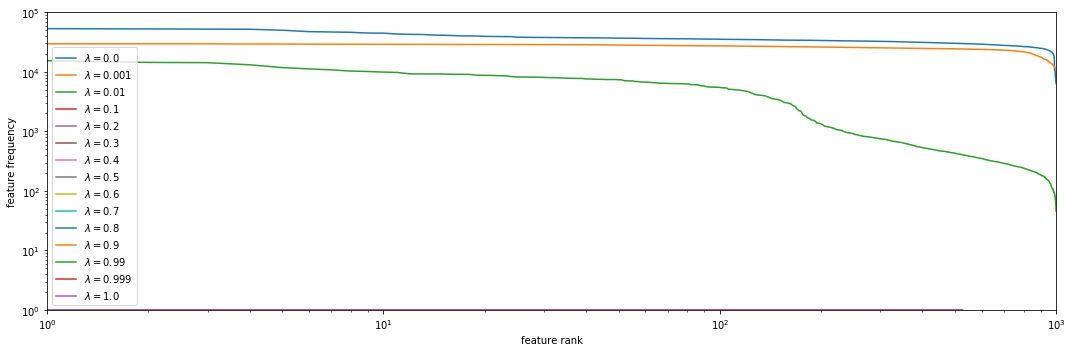

In [5]:
plot_feature_frequency('uniform')

### Zipf Sparse Embeddings
#### Inverse Zipf embeddings
We update the Word2Bits loss function $J(\mathbf{u}_o, \hat{\mathbf{v}}_c)$ from
$$\begin{align*}
J(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left(-\log\left(\sigma\left((\mathbf{u}_o)^T\hat{\mathbf{v}}_c\right)\right) - \sum_{i=1}^k\log\left(\sigma\left((-\mathbf{u}_i)^T\hat{\mathbf{v}}_c\right)\right)\right) \\
                                    &= \alpha\cdot\left(-\log\left(\sigma\left(\sum_{j=1}^D u_{oj}\cdot\hat{v}_{cj}\right)\right) - \sum_{i=1}^k\log\left(\sigma\left(\sum_{j=1}^D -u_{ij}\cdot\hat{v}_{cj}\right)\right)\right) \\
\end{align*}$$
to $$\begin{align*}
J'_{\text{Mk1}}(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left(\left(-\log\left(\sigma\left(\sum_{j=1}^D \left(1-\lambda\cdot\frac jD\right)\cdot u_{oj}\cdot\hat{v}_{cj}\right)\right) - \sum_{i=1}^k\log\left(\sigma\left(\sum_{j=1}^D \left(1-\lambda\cdot\frac jD\right)\cdot -u_{ij}\cdot\hat{v}_{cj}\right)\right)\right)\right. \\
                                     &+ \left.\left(\sum_{j=1}^{D}\lambda\cdot\frac jD\cdot\left(u_{oj} + \sum_{-w+o\leq i\leq w+o, i\neq o}v_{ij}\right)\right)\right), \\
\end{align*}$$ where $\alpha$ is the learning rate, and $\frac jD$ modulates $\lambda$ proportionally to the inverse PMF of the Zipf distribution ($s=1$). The following plot shows feature frequencies as we change $\lambda$.

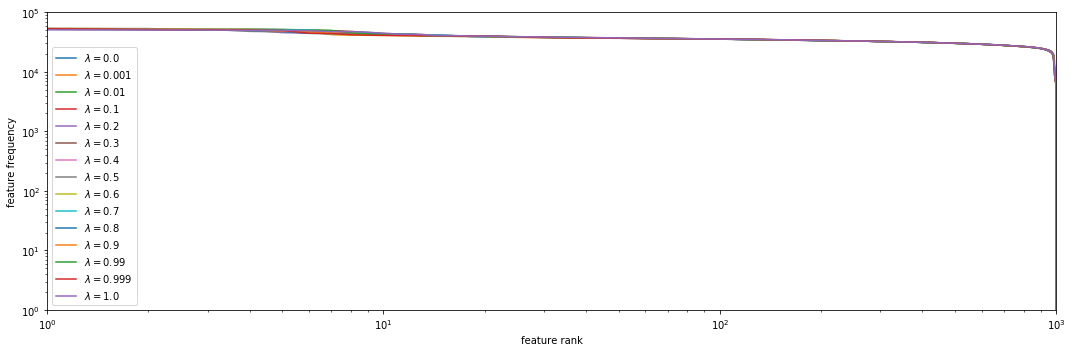

In [6]:
plot_feature_frequency('zipf-mk1')

As an alternative loss function uses $\alpha$ only as the learning rate for $J$: $$\begin{align*}
J'_{\text{Mk2}}(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left(\left(-\log\left(\sigma\left(\sum_{j=1}^D \left(1-\lambda\cdot\frac jD\right)\cdot u_{oj}\cdot\hat{v}_{cj}\right)\right) - \sum_{i=1}^k\log\left(\sigma\left(\sum_{j=1}^D \left(1-\lambda\cdot\frac jD\right)\cdot -u_{ij}\cdot\hat{v}_{cj}\right)\right)\right)\right) \\
                                     &+ \left(\sum_{j=1}^{D}\lambda\cdot\frac jD\cdot\left(u_{oj} + \sum_{-w+o\leq i\leq w+o, i\neq o}v_{ij}\right)\right). \\
\end{align*}$$

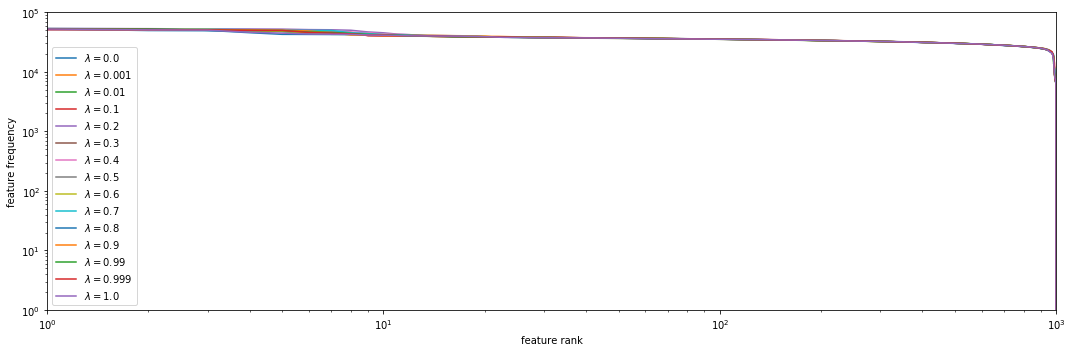

In [7]:
plot_feature_frequency('zipf-mk2')

As an alternative loss function does not use $\lambda$ in $J$ at all: $$\begin{align*}
J'_{\text{Mk3}}(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot J(\mathbf{u}_o, \hat{\mathbf{v}}_c)+ \left(\sum_{j=1}^{D}\lambda\cdot\frac jD\cdot\left(u_{oj} + \sum_{-w+o\leq i\leq w+o, i\neq o}v_{ij}\right)\right). \\
\end{align*}$$

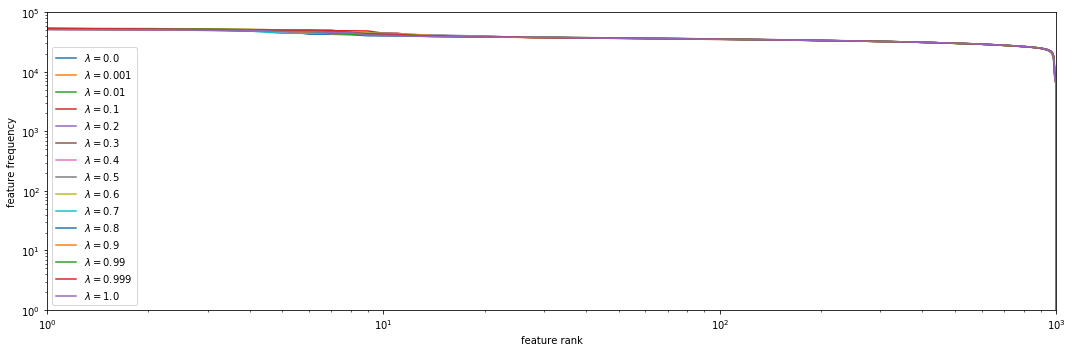

In [12]:
plot_feature_frequency('zipf-mk3')

Moving $J'_{\text{Mk2}}$ closer to `4c6f4c3`, we introduce a mistake to the gradient, producing a different loss function $J'_{\text{Mk7}}$.

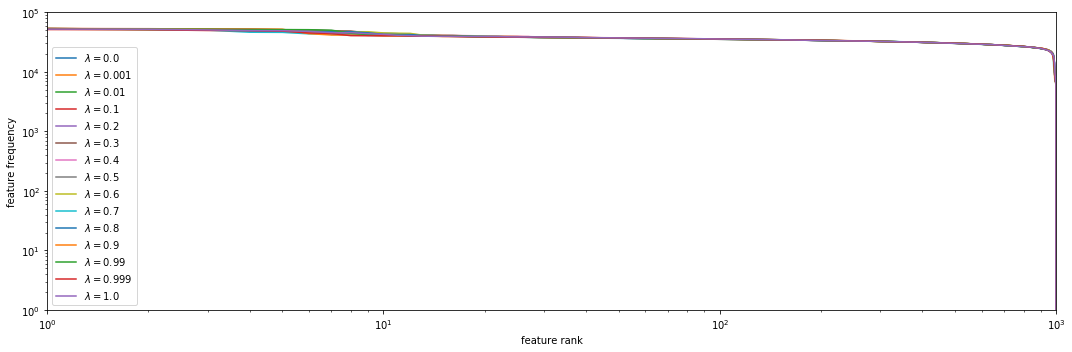

In [13]:
plot_feature_frequency('zipf-mk7')

Moving $J'_{\text{Mk7}}$ closer to `4c6f4c3`, we index from zero instead of one in $\lambda\cdot\frac jD$: $$\begin{align*}
J'_{\text{Mk8}}(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left(\left(-\log\left(\sigma\left(\sum_{j=1}^D \left(1-\lambda\cdot\frac{j-1}D\right)\cdot u_{oj}\cdot\hat{v}_{cj}\right)\right) - \sum_{i=1}^k\log\left(\sigma\left(\sum_{j=1}^D \left(1-\lambda\cdot\frac{j-1}D\right)\cdot -u_{ij}\cdot\hat{v}_{cj}\right)\right)\right)\right) \\
                                     &+ \left(\sum_{j=1}^{D}\lambda\cdot\frac{j-1}D\cdot\left(u_{oj} + \sum_{-w+o\leq i\leq w+o, i\neq o}v_{ij}\right)\right). \\
\end{align*}$$

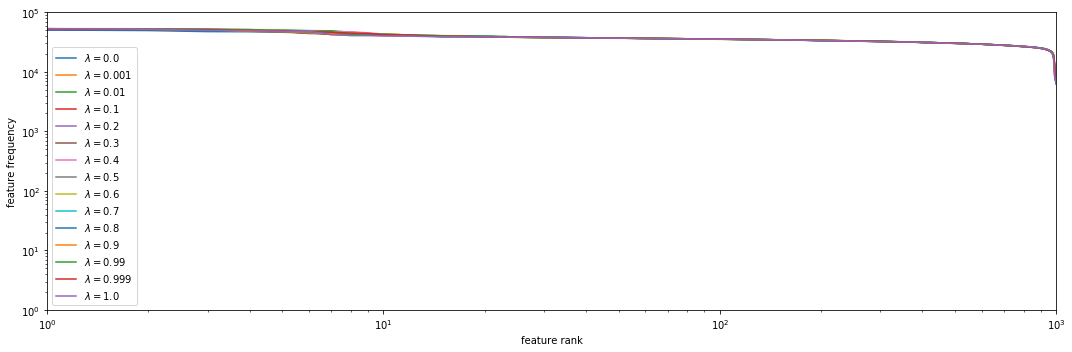

In [14]:
plot_feature_frequency('zipf-mk8')

Moving $J'_{\text{Mk8}}$ closer to `4c6f4c3`, we transform the sparsification factor using the sigmoid ($\sigma$) function: $$\begin{align*}
J'_{\text{Mk9}}(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left(\left(-\log\left(\sigma\left(\sum_{j=1}^D \left(1-\lambda\cdot\frac{j-1}D\right)\cdot u_{oj}\cdot\hat{v}_{cj}\right)\right) - \sum_{i=1}^k\log\left(\sigma\left(\sum_{j=1}^D \left(1-\lambda\cdot\frac{j-1}D\right)\cdot -u_{ij}\cdot\hat{v}_{cj}\right)\right)\right)\right) \\
                                     &+ \left(\sum_{j=1}^{D}\lambda\cdot\frac{j-1}D\cdot\left(\sigma(u_{oj}) + \sum_{-w+o\leq i\leq w+o, i\neq o}\sigma(v_{ij})\right)\right). \\
\end{align*}$$

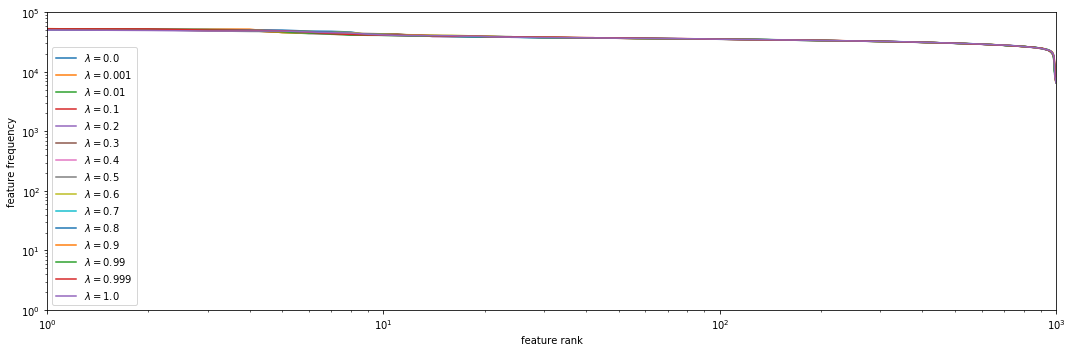

In [17]:
plot_feature_frequency('zipf-mk9')

Switching to `4c6f4c3`, we produce the loss function $J'_{\text{Mk13}}$.

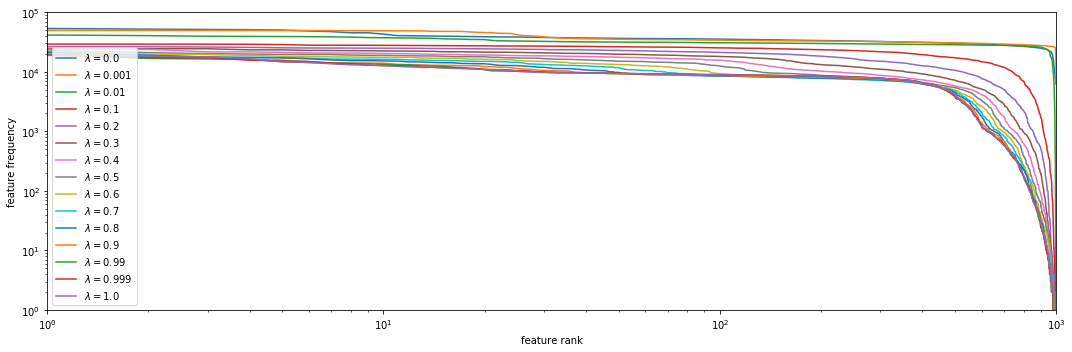

In [20]:
plot_feature_frequency('zipf-mk13')

#### Forward Zipf embeddings
We update the Word2Bits loss function $J(\mathbf{u}_o, \hat{\mathbf{v}}_c)$ from
$$\begin{align*}
J(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left(-\log\left(\sigma\left((\mathbf{u}_o)^T\hat{\mathbf{v}}_c\right)\right) - \sum_{i=1}^k\log\left(\sigma\left((-\mathbf{u}_i)^T\hat{\mathbf{v}}_c\right)\right)\right) \\
                                    &= \alpha\cdot\left(-\log\left(\sigma\left(\sum_{j=1}^D u_{oj}\cdot\hat{v}_{cj}\right)\right) - \sum_{i=1}^k\log\left(\sigma\left(\sum_{j=1}^D -u_{ij}\cdot\hat{v}_{cj}\right)\right)\right) \\
\end{align*}$$
to $$\begin{align*}
J'_{\text{Mk4}}(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left(\left(-\log\left(\sigma\left(\sum_{j=1}^D \left(1-\frac\lambda j\right)\cdot u_{oj}\cdot\hat{v}_{cj}\right)\right) - \sum_{i=1}^k\log\left(\sigma\left(\sum_{j=1}^D \left(1-\frac\lambda j\right)\cdot -u_{ij}\cdot\hat{v}_{cj}\right)\right)\right)\right. \\
                                     &+ \left.\left(\sum_{j=1}^{D}\frac\lambda j\cdot\left(u_{oj} + \sum_{-w+o\leq i\leq w+o, i\neq o}v_{ij}\right)\right)\right), \\
\end{align*}$$ where $\alpha$ is the learning rate, and $j$ modulates $\lambda$ proportionally to the PMF of the Zipf distribution ($s=1$). The following plot shows feature frequencies as we change $\lambda$.

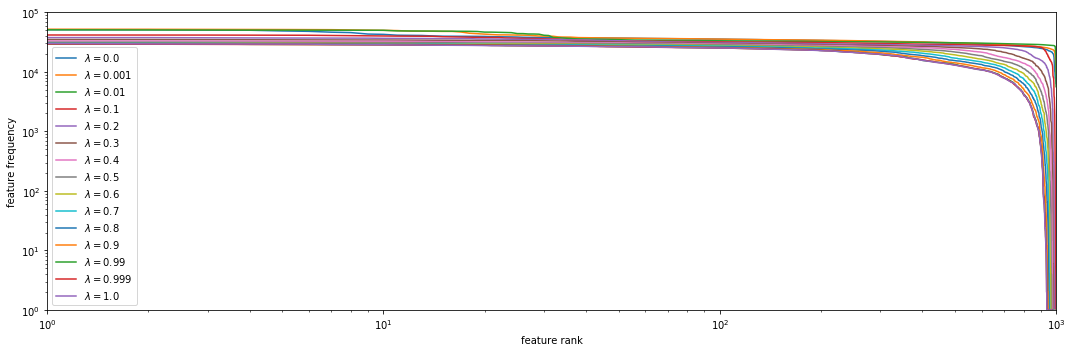

In [8]:
plot_feature_frequency('zipf-mk4')

As an alternative loss function uses $\alpha$ only as the learning rate for $J$: $$\begin{align*}
J'_{\text{Mk5}}(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left(\left(-\log\left(\sigma\left(\sum_{j=1}^D \left(1-\frac\lambda j\right)\cdot u_{oj}\cdot\hat{v}_{cj}\right)\right) - \sum_{i=1}^k\log\left(\sigma\left(\sum_{j=1}^D \left(1-\frac\lambda j\right)\cdot -u_{ij}\cdot\hat{v}_{cj}\right)\right)\right)\right) \\
                                     &+ \left(\sum_{j=1}^{D}\frac\lambda j\cdot\left(u_{oj} + \sum_{-w+o\leq i\leq w+o, i\neq o}v_{ij}\right)\right). \\
\end{align*}$$

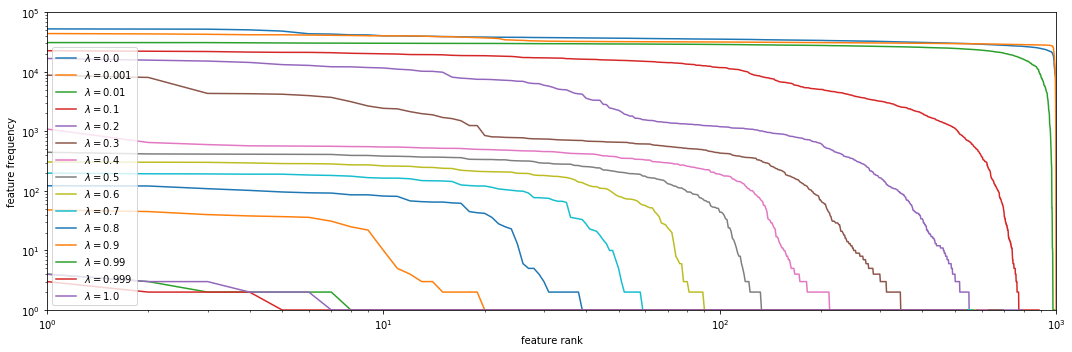

In [9]:
plot_feature_frequency('zipf-mk5')

As an alternative loss function does not use $\lambda$ in $J$ at all: $$\begin{align*}
J'_{\text{Mk6}}(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot J(\mathbf{u}_o, \hat{\mathbf{v}}_c)+ \left(\sum_{j=1}^{D}\frac\lambda j\cdot\left(u_{oj} + \sum_{-w+o\leq i\leq w+o, i\neq o}v_{ij}\right)\right). \\
\end{align*}$$

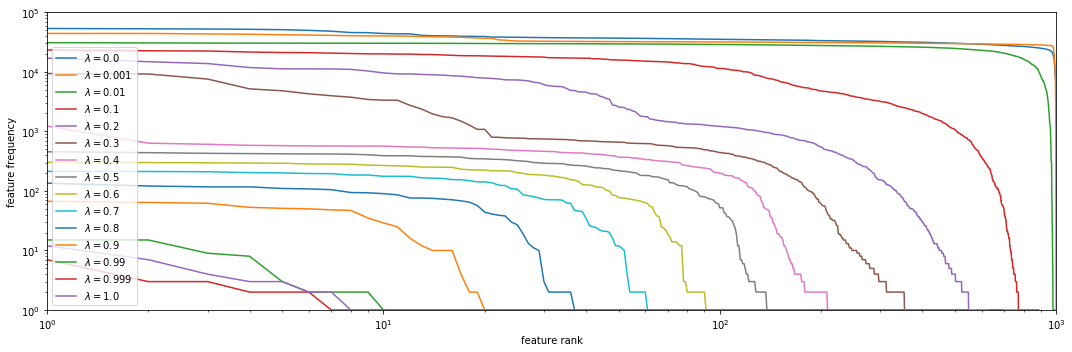

In [10]:
plot_feature_frequency('zipf-mk6')

Moving $J'_{\text{Mk5}}$ closer to `4a40595`, we introduce a mistake to the gradient, producing a different loss function $J'_{\text{Mk10}}$.

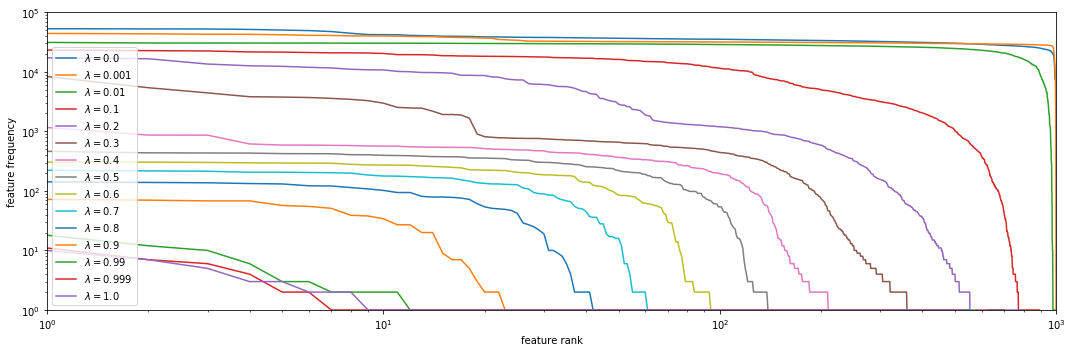

In [15]:
plot_feature_frequency('zipf-mk10')

Moving $J'_{\text{Mk10}}$ closer to `4a40595`, we index from zero instead of one in $\lambda\cdot\frac jD$: $$\begin{align*}
J'_{\text{Mk11}}(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left(\left(-\log\left(\sigma\left(\sum_{j=1}^D \left(1-\frac\lambda{j-1}\right)\cdot u_{oj}\cdot\hat{v}_{cj}\right)\right) - \sum_{i=1}^k\log\left(\sigma\left(\sum_{j=1}^D \left(1-\frac\lambda{j-1}\right)\cdot -u_{ij}\cdot\hat{v}_{cj}\right)\right)\right)\right) \\
                                     &+ \left(\sum_{j=1}^{D}\frac\lambda{j-1}\cdot\left(u_{oj} + \sum_{-w+o\leq i\leq w+o, i\neq o}v_{ij}\right)\right). \\
\end{align*}$$

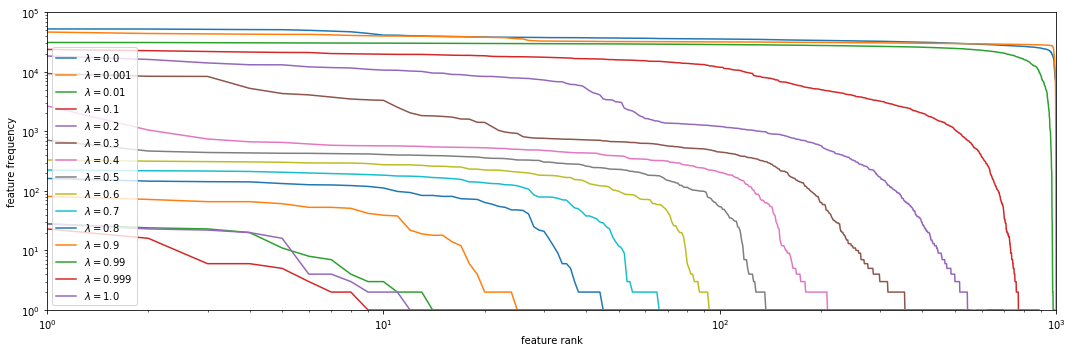

In [16]:
plot_feature_frequency('zipf-mk11')

Moving $J'_{\text{Mk11}}$ closer to `4a40595`, we transform the sparsification factor using the sigmoid ($\sigma$) function: $$\begin{align*}
J'_{\text{Mk12}}(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left(\left(-\log\left(\sigma\left(\sum_{j=1}^D \left(1-\frac\lambda{j-1}\right)\cdot u_{oj}\cdot\hat{v}_{cj}\right)\right) - \sum_{i=1}^k\log\left(\sigma\left(\sum_{j=1}^D \left(1-\frac\lambda{j-1}\right)\cdot -u_{ij}\cdot\hat{v}_{cj}\right)\right)\right)\right) \\
                                     &+ \left(\sum_{j=1}^{D}\frac\lambda{j-1}\cdot\left(\sigma(u_{oj}) + \sum_{-w+o\leq i\leq w+o, i\neq o}\sigma(v_{ij})\right)\right). \\
\end{align*}$$

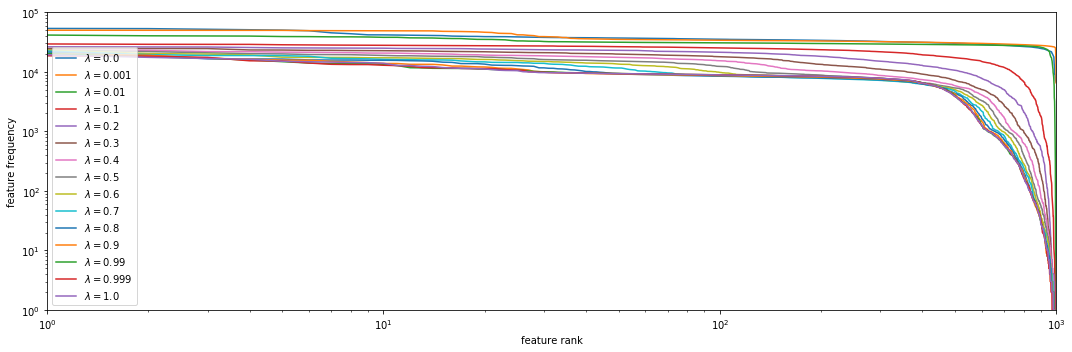

In [18]:
plot_feature_frequency('zipf-mk12')

Switching to `4a40595`, we produce the loss function $J'_{\text{Mk14}}$.

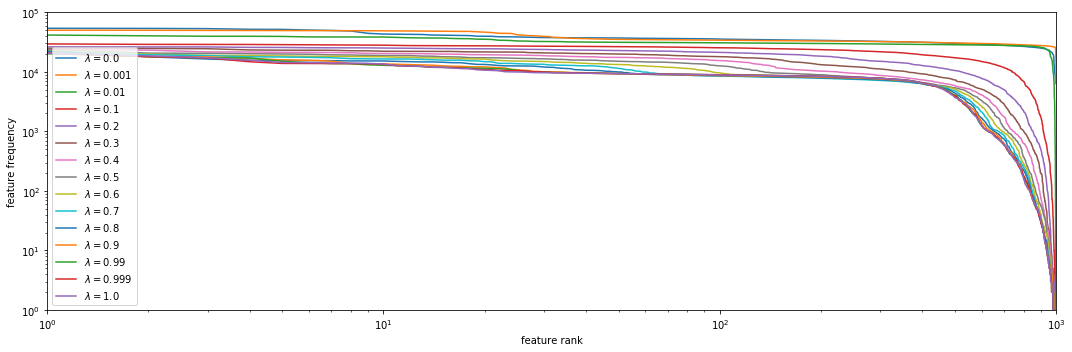

In [21]:
plot_feature_frequency('zipf-mk14')

### Exponential Sparse Embeddings
We update the Word2Bits loss function $J(\mathbf{u}_o, \hat{\mathbf{v}}_c)$ from
$$\begin{align*}
J(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left(-\log\left(\sigma\left((\mathbf{u}_o)^T\hat{\mathbf{v}}_c\right)\right) - \sum_{i=1}^k\log\left(\sigma\left((-\mathbf{u}_i)^T\hat{\mathbf{v}}_c\right)\right)\right) \\
                                    &= \alpha\cdot\left(-\log\left(\sigma\left(\sum_{j=1}^D u_{oj}\cdot\hat{v}_{cj}\right)\right) - \sum_{i=1}^k\log\left(\sigma\left(\sum_{j=1}^D -u_{ij}\cdot\hat{v}_{cj}\right)\right)\right) \\
\end{align*}$$
to $$\begin{align*}
J'(\mathbf{u}_o, \hat{\mathbf{v}}_c) &= \alpha\cdot\left(\left(-\log\left(\sigma\left(\sum_{j=1}^D (1-\lambda)^j\cdot u_{oj}\cdot\hat{v}_{cj}\right)\right) - \sum_{i=1}^k\log\left(\sigma\left(\sum_{j=1}^D (1-\lambda)^j\cdot -u_{ij}\cdot\hat{v}_{cj}\right)\right)\right)\right. \\
                                     &+ \left.\left(\sum_{j=1}^{D}\left(1-(1-\lambda)^j\right)\cdot\left(u_{oj} + \sum_{-w+o\leq i\leq w+o, i\neq o}v_{ij}\right)\right)\right), \\
\end{align*}$$ where $\alpha$ is the learning rate, and $j$ modulates $\lambda$ exponentially. The following plot shows feature frequencies as we change $\lambda$.

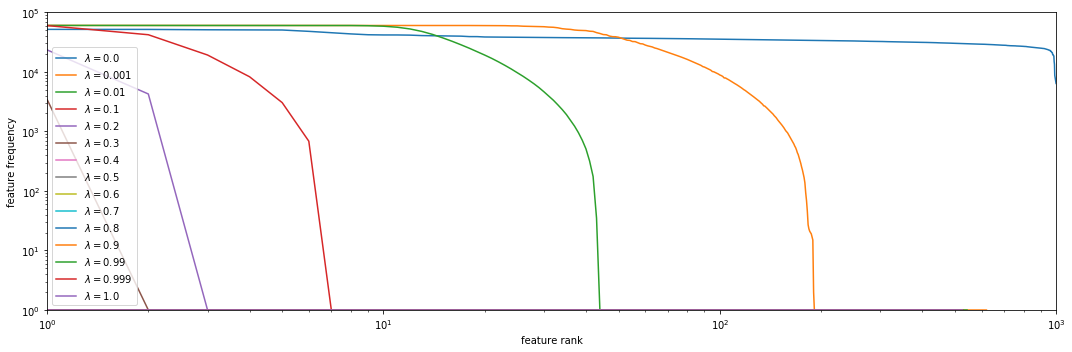

In [11]:
plot_feature_frequency('exponential')

## Evaluation
### Correlation with Parts of Speech
To test the hypothesis that “lexical” Word2Bits embeddings are highly correlated with high-level features such as parts of speech, we plot the maximum absolute correlation coefficient of feature for all the above word embeddings and lambdas.

In [107]:
from itertools import chain, cycle, product

import majka
from majka import Majka

make('w-lt.en.fsa')
morph = Majka("w-lt.en.fsa")
morph.flags |= majka.IGNORE_CASE
morph.tags = True

embedding_names = tuple(chain(
    ('uniform', 'exponential'),
    ('zipf-mk{}'.format(mark) for mark in range(1, 15)),
))

def tag_word(word):
    """Returns parts-of-speech tags for a word.
    
    Parameters
    ----------
    word : str
        A word.
    
    Returns
    -------
    set
        The parts-of-speech tags for the word.
    """
    
    return set(lemma["tags"]["other"] for lemma in morph.find(str(word)))


def max_corrcoeff(embeddings):
    """Returns the maximum absolute correlation coefficient of a word embedding feature and a parts-of-speech tag.
    
    Parameters
    ----------
    embeddings : gensim.models.keyedvectors.Word2VecKeyedVectors
        Word embeddings.
    
    Returns
    -------
    np.float64
        The maximum absolute correlation coefficient of a word embedding feature and a parts-of-speech tag.
    """
    words = embeddings.index2entity
    tags = list(set.union(*map(tag_word, words)))

    feature_matrix = embeddings.vectors
    tag_matrix = np.array([[(tag in tag_word(word)) for tag in tags] for word in words], dtype=bool)

    num_features = feature_matrix.shape[1]
    num_tags = len(tags)

    corrcoeff = np.nan_to_num(np.corrcoef(feature_matrix.T, tag_matrix.T))
    max_corrcoeff = np.abs(corrcoeff[:num_features, num_features:num_features + num_tags]).max()
    return max_corrcoeff


def plot_max_corrcoeff(embedding_names):
    """Plots the maximum absolute correlation coefficient of a word embedding feature and a parts-of-speech tag.

    Parameters
    ----------
    embedding_names : iterable of str
        The names of the word embeddings.
    """
    
    line_formats = cycle(product(['C{}'.format(colornum) for colornum in range(10)], ['-', '--', '-.', ':']))
    plt.figure(figsize=(15, 5))
    for embedding_name in embedding_names:
        max_corrcoeffs = []
        for l in lambdas:
            filename = 'vectors/{}_sparsification/1b_1000d_vectors_{}_e10_nonbin'.format(embedding_name, l)
            make(filename)
            embeddings = KeyedVectors.load_word2vec_format(filename, binary=False)
            max_corrcoeffs.append(max_corrcoeff(embeddings))
        color, linestyle = next(line_formats)
        plt.plot(lambdas, max_corrcoeffs, label=embedding_name, linestyle=linestyle, color=color)
    plt.xlabel(r'$\lambda$')
    plt.ylabel('maximum correlation coefficient')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('figures/max_corrcoeffs.pdf')
    plt.show()

2019-04-03 16:01:12,492 : INFO : Making target w-lt.en.fsa


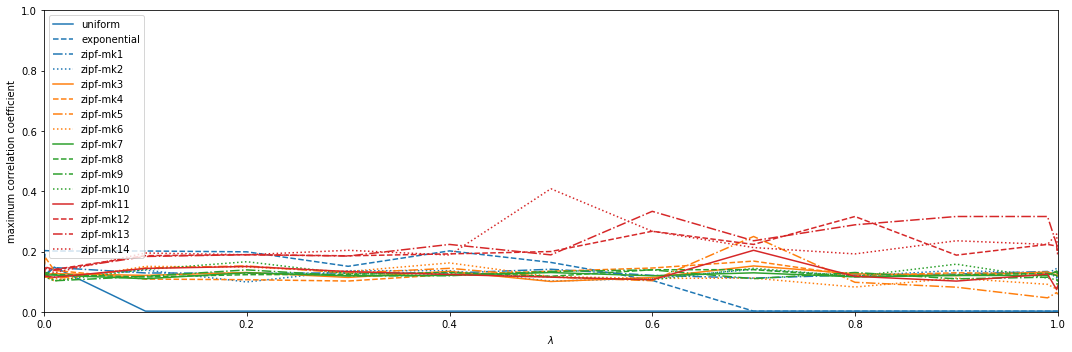

In [108]:
plot_max_corrcoeff(embedding_names)